In [20]:
from __future__ import print_function
import os
import sys
import time
import torch
import math
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from enum import Enum
import dlib
import FANet
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import FAutils as utils

# dlib based face detector
path_to_detector = '/home/zhshu/.face_alignment/data/mmod_human_face_detector.dat'
face_detector = dlib.cnn_face_detection_model_v1(path_to_detector)
def detect_faces(image):
    return face_detector(image, 1)
    
fan_net = FANet.FAN(4) 

fan_path = '/nfs/bigdisk/zhshu/Github/data/2DFAN-4.pth.tar'
fan_weights = torch.load(fan_path,
                         map_location=lambda storage,
                         loc: storage)
fan_net.load_state_dict(fan_weights)
fan_net.cuda()
fan_net.eval()

fan_net_3D = FANet.FAN(4) 
fan_path_3D = '/nfs/bigdisk/zhshu/Github/data/3DFAN-4.pth.tar'
fan_weights_3D = torch.load(fan_path_3D,
                         map_location=lambda storage,
                         loc: storage)
fan_net_3D.load_state_dict(fan_weights_3D)
fan_net_3D.cuda()
fan_net_3D.eval()


depth_prediciton_net = FANet.ResNetDepth()
depth_model_path = '/nfs/bigdisk/zhshu/Github/data/depth.pth.tar'

depth_weights = torch.load(depth_model_path,
                           map_location=lambda storage,
                           loc: storage)
depth_dict = {
    k.replace('module.', ''): v for k,
    v in depth_weights['state_dict'].items()}
depth_prediciton_net.load_state_dict(depth_dict)
depth_prediciton_net.cuda()
depth_prediciton_net.eval()


def get_landmarks_3D(input_image, face_alignment_net = fan_net_3D, all_faces=False):
    if isinstance(input_image, str):
        try:
            image = io.imread(input_image)
        except IOError:
            print("error opening file :: ", input_image)
            return None
    else:
        image = input_image

    detected_faces = detect_faces(image)
    if len(detected_faces) > 0:
        landmarks = []
        for i, d in enumerate(detected_faces):
            if i > 1 and not all_faces:
                break
            d = d.rect
            center = torch.FloatTensor(
                [d.right() - (d.right() - d.left()) / 2.0, d.bottom() -
                 (d.bottom() - d.top()) / 2.0])
            center[1] = center[1] - (d.bottom() - d.top()) * 0.12
            scale = (d.right() - d.left() + d.bottom() - d.top()) / 195.0

            inp = utils.crop(image, center, scale)
            croppy = inp
            print(croppy.shape)
            inp = torch.from_numpy(inp.transpose((2, 0, 1))).float().div(255.0).unsqueeze_(0)          
            inp = inp.cuda()

            out = face_alignment_net(Variable(inp, volatile=True))[-1].data.cpu()

            pts, pts_img = utils.get_preds_fromhm(out, center, scale)
            pts, pts_img = pts.view(68, 2) * 4, pts_img.view(68, 2)

            heatmaps = np.zeros((68, 256, 256))
            for i in range(68):
                if pts[i, 0] > 0:
                    heatmaps[i] = utils.draw_gaussian(heatmaps[i], pts[i], 2)
            heatmaps = torch.from_numpy(heatmaps).view(1, 68, 256, 256).float()
            heatmaps = heatmaps.cuda()
            depth_pred = depth_prediciton_net(Variable(torch.cat((inp, heatmaps), 1), volatile=True)).data.cpu().view(68, 1)
            pts_img = torch.cat((pts_img, depth_pred * (1.0 / (256.0 / (200.0 * scale)))), 1)

            landmarks.append(pts_img.numpy())
    else:
        print("Warning: No faces were detected.")
        return None

    return d, croppy, landmarks

(256, 256, 3)


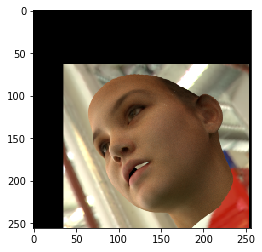

In [26]:

#img = io.imread('/nfs/bigdisk/zhshu/data/fare/real/multipie_select_batches/session01_select_test/light_19_052_02/052_01_02_190_19.png')
img = io.imread('/nfs/bigdisk/zhshu/data/fare/renderfile_v3_f1001to2000/idp98/fare_img_ids_1136_ide_1136_idp_98_idt_1136_idl_env013.png')
#img = io.imread('/nfs/bigdisk/zhshu/data/fare/real/multipie_select_batches/session01_select_test/light_00_012_01/012_01_01_010_00.png')
img_crop_rec , img_crop, img_lms = get_landmarks_3D(img)
imgplot = plt.imshow(img_crop)
plt.show()

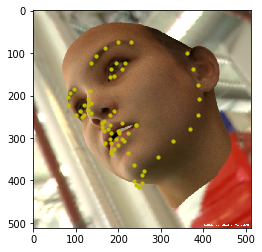

In [27]:
def DrawPointsOnImage(img,points):
    imgplot = plt.imshow(img)
    for i in range(68):
        plt.scatter(points[0][i][0], points[0][i][1], c='y', s=10)
    plt.show()
DrawPointsOnImage(img, img_lms)